# Judge Hiciano Jupyter Notebook

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [94]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import statsmodels

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb



In [237]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

In [238]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")

In [239]:
common_drops = ['sessionID',
                'customerID',
                'weekday',
#                 'status',
#                'availability',
#                 'cartStep',
                 'purchase',
#                 'score',                 
                'payments',
                'account',
                'lastOrder',
                 'salutation',
                 'age',
#                 'cartCount',
#                 'clickMin',
#                 'cartMin',
#                 'hour',
                'duration',
#                 'clickCount',
#                 'clickMax',
#                 'cartMax',
#                 'clickTotal',
#                 'cartTotal'
               ]

#common_drops = ['sessionID','hour','weekday','duration','clickTotal']
drop_columns_train = common_drops
drop_columns_submission = common_drops

## Feature Enigneering on Training Data

### Adding new variables to train and fill missing values for certain columns

In [252]:
def feat_eng(df_train, train=False):
    """ Added additional features to dataframe and returns two dataframes.
            customer and non-customer dataframe
    """
    # Get a total number of entries per sessionID
    df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')

    # Get a count of the number of customer 
    df_train['customer_total_orders'] = df_train.groupby('customerID')['customerID'].transform('count')

    # Gets the total duration for a given session
    df_train['total_duration'] = df_train.groupby('sessionID')['duration'].transform('sum')

    # Fills cartStep NaN with -1
    df_train['cartStep'].fillna(-1, inplace=True)

    # Gets the difference between clickTotal and CartTotal
    df_train['missing_items_total'] = df_train['clickTotal']-df_train['cartTotal']

    # Converts order and status from y and n to 1 and 0
    if train:
        df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
        
    df_train['status'] = (df_train['status'] !='n').astype(int) #Converts string `order` to int value for training
    
    # Drop Columns
    df_train = df_train.drop("availability",axis=1)
    df_train = df_train.drop("weekday",axis=1)
    df_train = df_train.drop("status",axis=1)

    cust = df_train[df_train['customerID'].notnull()]
    noncust =df_train[df_train['customerID'].isnull()]
    cust.fillna(-1, inplace=True)
    noncust.fillna(-1, inplace=True)
    
    return cust , noncust

In [253]:
df_train_cust, df_train_noncust = feat_eng(df_train, True)
df_test_cust, df_test_noncust = feat_eng(df_test)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


### Customer Dataset

In [254]:
df_train_cust.info()
df_train_noncust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277915 entries, 0 to 429012
Data columns (total 26 columns):
sessionID                277915 non-null int64
hour                     277915 non-null int64
duration                 277915 non-null float64
clickCount               277915 non-null int64
clickMin                 277915 non-null float64
clickMax                 277915 non-null float64
clickTotal               277915 non-null float64
cartCount                277915 non-null int64
cartMin                  277915 non-null float64
cartMax                  277915 non-null float64
cartTotal                277915 non-null float64
cartStep                 277915 non-null float64
customerID               277915 non-null float64
purchase                 277915 non-null float64
score                    277915 non-null float64
account                  277915 non-null float64
payments                 277915 non-null float64
age                      277915 non-null float64
salutation     

### Non-Customer Dataset

#### Drop customer related columns from non-customer dataset

In [255]:
common_columns = ['customer_total_orders','customerID','purchase','score','account','payments','age','salutation','lastOrder']
drop_columns_submission_train = common_columns + ['order']
drop_columns_submission_test = common_columns
df_train_noncust = df_train_noncust.drop(drop_columns_submission_train,axis=1)
df_test_noncust = df_test_noncust.drop(drop_columns_submission_test,axis=1)

In [285]:
df_test_noncust.describe()

,sessionID,hour,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,sess_count,total_duration,missing_items_total
count,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,17264.000000,1.726400e+04,17264.000000
mean,52524.701923,17.885774,1562.960341,23.257472,81.189796,183.537978,1509.530108,3.570957,98.384870,138.004329,251.713891,0.895273,15.246119,3.890353e+04,1255.873798
std,1483.115726,6.378559,2361.243807,30.110798,189.655306,317.151708,4900.742374,3.989204,219.764178,254.451484,537.148861,1.871450,14.140504,1.048377e+05,4529.983119
min,50007.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000e+00,-1.000000
25%,51220.000000,19.000000,193.568750,4.000000,6.990000,29.990000,133.970000,1.000000,9.990000,19.990000,37.960000,-1.000000,6.000000,2.169021e+03,59.950000
50%,52515.000000,20.000000,751.036500,12.000000,14.990000,59.950000,421.340000,2.000000,19.990000,39.990000,84.970000,1.000000,12.000000,1.001679e+04,295.810000
75%,53771.000000,21.000000,1931.277750,30.000000,49.990000,169.000000,1239.810000,4.000000,49.990000,99.990000,243.155000,2.000000,19.000000,3.130607e+04,979.810000
max,55111.000000,23.000000,20998.835000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,87.000000,1.172623e+06,108950.790000


## Adjust Testing Data Set

In [257]:
def match_column(df_train, df_test):
    column_order = []
    for col in df_train.columns: 
        column_order.append(col)
    print(column_order)
    column_order.remove('ordered')
    return df_test[column_order]


In [258]:
df_test_noncust = match_column(df_train_noncust,df_test_noncust)
df_test_noncust.info()
df_train_noncust.info()

['sessionID', 'hour', 'duration', 'clickCount', 'clickMin', 'clickMax', 'clickTotal', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'sess_count', 'total_duration', 'missing_items_total', 'ordered']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17264 entries, 54 to 45067
Data columns (total 15 columns):
sessionID              17264 non-null int64
hour                   17264 non-null int64
duration               17264 non-null float64
clickCount             17264 non-null int64
clickMin               17264 non-null float64
clickMax               17264 non-null float64
clickTotal             17264 non-null float64
cartCount              17264 non-null int64
cartMin                17264 non-null float64
cartMax                17264 non-null float64
cartTotal              17264 non-null float64
cartStep               17264 non-null float64
sess_count             17264 non-null int64
total_duration         17264 non-null float64
missing_items_total    17264 non-null float6

In [259]:
df_train_cust = df_train_cust.drop("order",axis=1)
df_test_cust = match_column(df_train_cust, df_test_cust)
df_test_cust.info()
df_train_cust.info()

['sessionID', 'hour', 'duration', 'clickCount', 'clickMin', 'clickMax', 'clickTotal', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'customerID', 'purchase', 'score', 'account', 'payments', 'age', 'salutation', 'lastOrder', 'sess_count', 'customer_total_orders', 'total_duration', 'missing_items_total', 'ordered']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27804 entries, 0 to 45039
Data columns (total 24 columns):
sessionID                27804 non-null int64
hour                     27804 non-null int64
duration                 27804 non-null float64
clickCount               27804 non-null int64
clickMin                 27804 non-null float64
clickMax                 27804 non-null float64
clickTotal               27804 non-null float64
cartCount                27804 non-null int64
cartMin                  27804 non-null float64
cartMax                  27804 non-null float64
cartTotal                27804 non-null float64
cartStep                 27804 non-null fl

## Create training and testing datasets

In [308]:
df_train_noncust_f = df_train_noncust.drop(['sessionID'],axis=1)
df_train_cust_f = df_train_cust.drop(['sessionID'],axis=1)
df_test_noncust_f = df_test_noncust.drop(['sessionID'],axis=1)
df_test_cust_f = df_test_cust.drop(['sessionID'],axis=1)

df_train_noncust_f = df_train_noncust_f.drop(['hour'],axis=1)
df_train_cust_f = df_train_cust_f.drop(['hour'],axis=1)
df_test_noncust_f = df_test_noncust_f.drop(['hour'],axis=1)
df_test_cust_f = df_test_cust_f.drop(['hour'],axis=1)

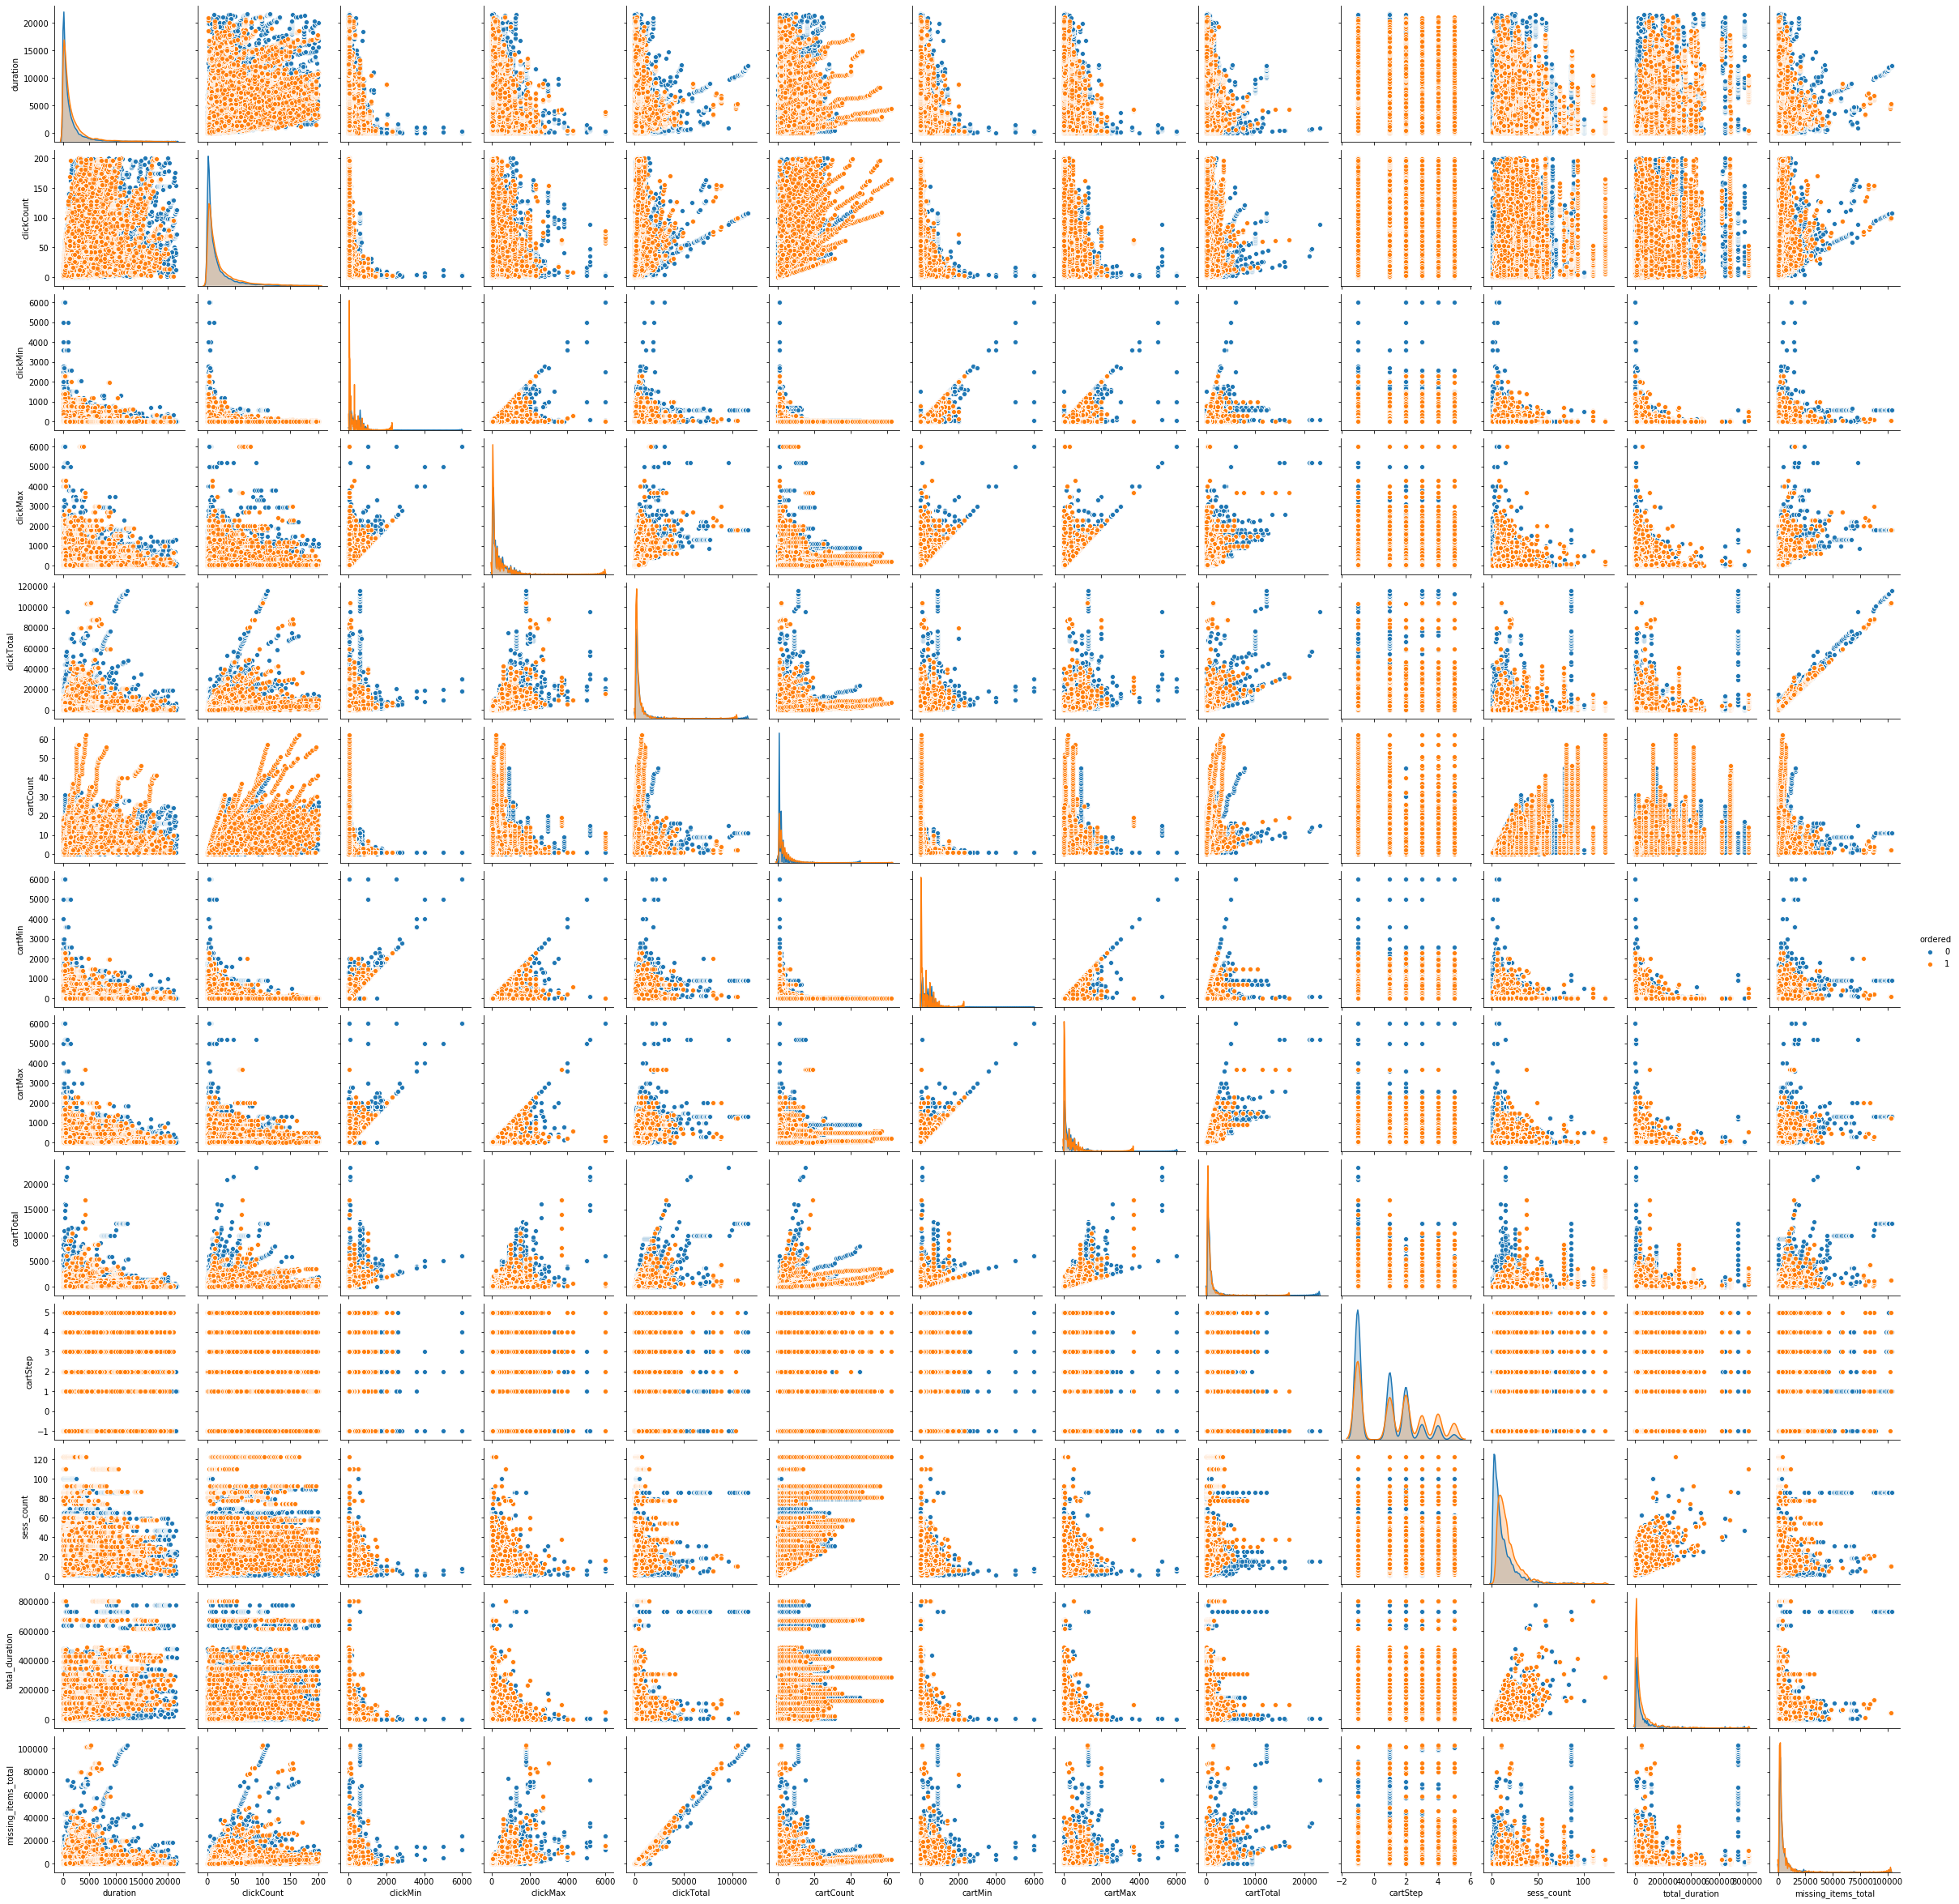

In [309]:
sns.pairplot(df_train_noncust_f, hue='ordered')

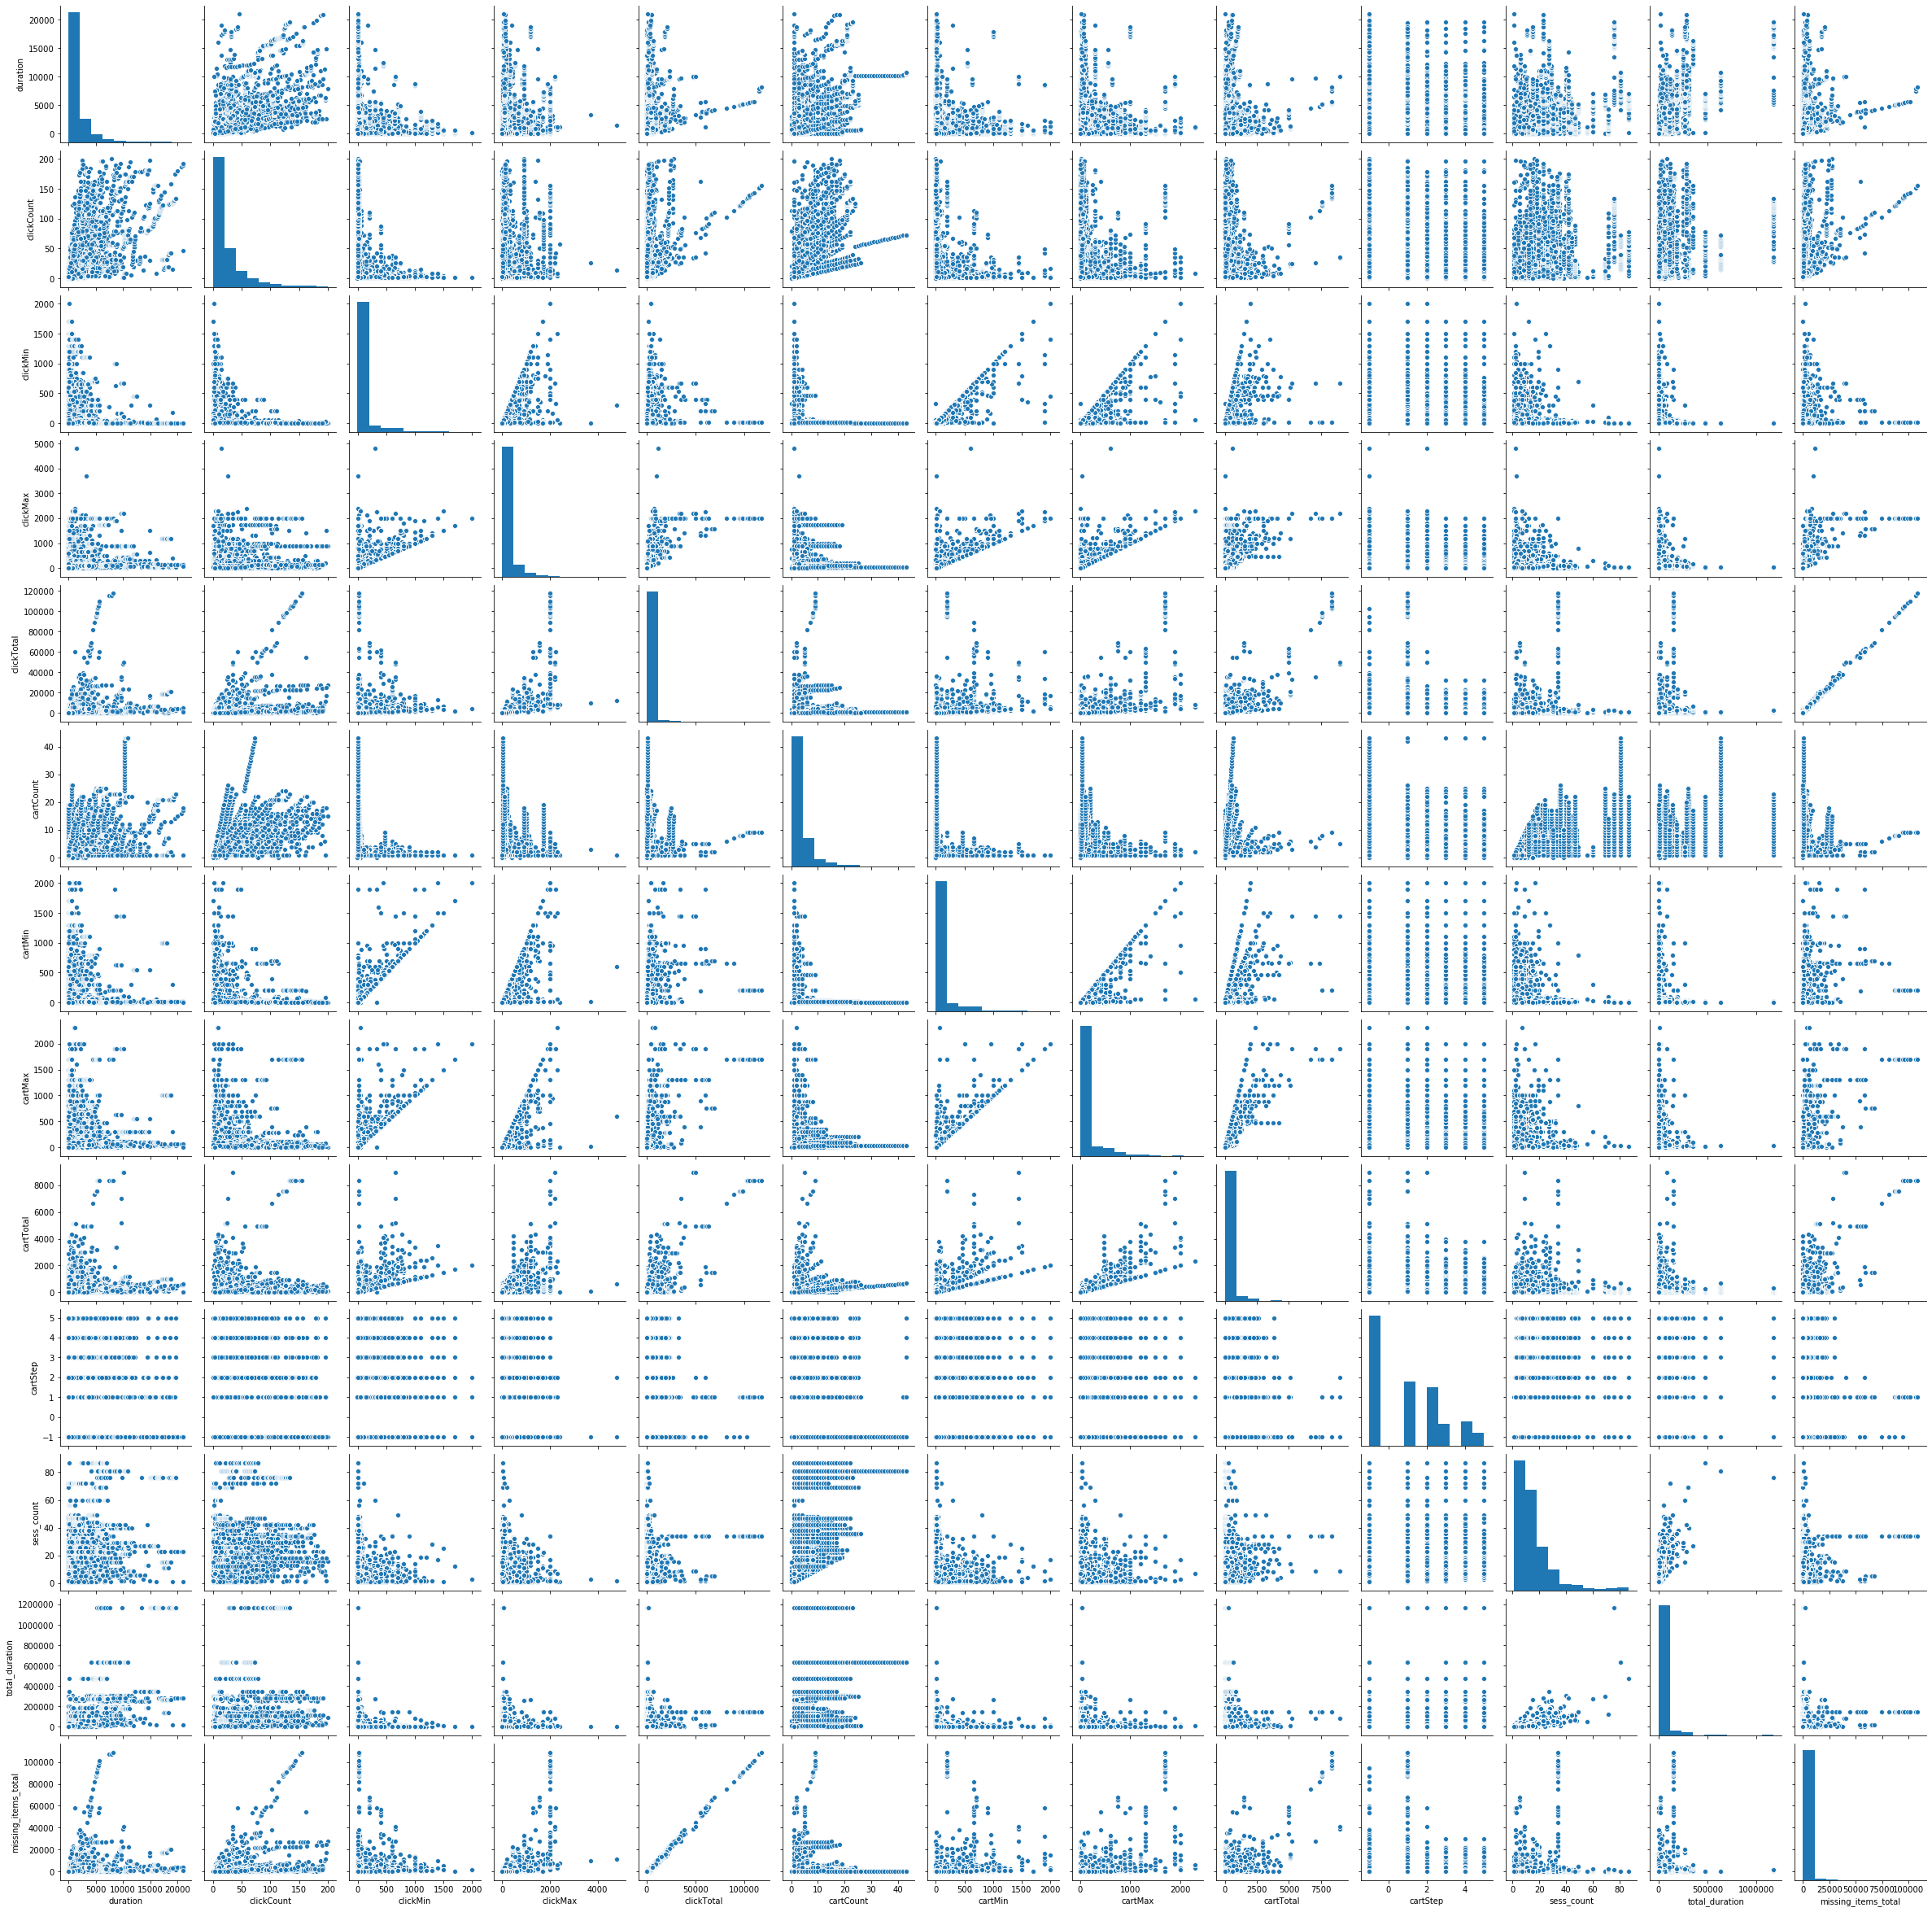

In [310]:
sns.pairplot(df_test_noncust_f)

In [311]:
X, y = df_train_noncust_f.drop(['ordered'],axis=1), df_train_noncust_f.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)

In [323]:
X, y = df_train_cust_f.drop(['ordered'],axis=1), df_train_cust_f.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=68)

In [312]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

#models.append(("RF",RandomForestClassifier()))
models.append(("RF Tunned",RandomForestClassifier(max_depth = 35,
                                                  n_estimators= 40,
                                                  random_state=0,
                                                  max_features='auto',
                                                  bootstrap=False,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2)))
#models.append(("Ada",AdaBoostClassifier()))
#models.append(("XGB",xgb.XGBClassifier()))
models.append(("Bagging",BaggingClassifier()))
#models.append(("Gradient",GradientBoostingClassifier()))
#models.append(("Hist",HistGradientBoostingClassifier,GradientBoostingClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=7, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

RF Tunned [0.94267184 0.94666744 0.94382673 0.94799629 0.94521659 0.94909659
 0.9485754 ]
Bagging [0.9103017  0.91846662 0.91620338 0.91070188 0.91597174 0.92315265
 0.91597174]


Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

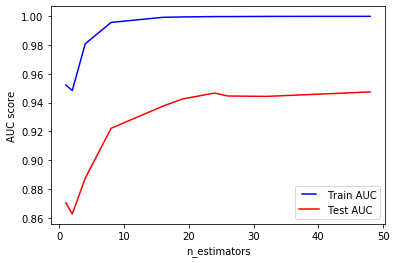

In [313]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 19,24,26, 32,48]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

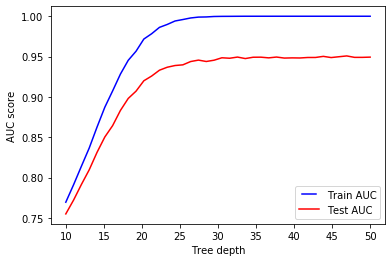

In [314]:
max_depths = np.linspace(10, 50, 40, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [324]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [1,2, 3,4,5, 10,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
oob_score=[True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score
              }


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 25,
                               cv = 7,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   29.8s
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [317]:
rc_random.best_params_

{'oob_score': True,
 'n_estimators': 38,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 44,
 'bootstrap': True}

In [318]:
clf2 = RandomForestClassifier(
                              oob_score=True,
                              max_depth = 44,
                              n_estimators=38,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=1,
                              min_samples_split=4)

In [ ]:
clf2 = RandomForestClassifier(
                              oob_score=True,
                              max_depth = 44,
                              n_estimators=38,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=1,
                              min_samples_split=4)

In [37]:
multi_target_forest = MultiOutputClassifier(clf2, n_jobs=-1)

In [100]:
clf2 = BaggingClassifier(oob_score=True,
                              n_estimators= 40,
                              random_state=0,
                              bootstrap=True)

In [319]:
clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=44, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=38,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 44,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 38,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


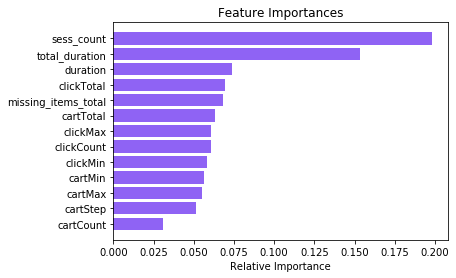

In [320]:
features = X_train.columns.values
importances = clf2.feature_importances_
indices = np.argsort(importances)
pprint(clf2.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [321]:
clf2.score(X_test, y_test)

0.94228987425546

In [322]:
results_non_cust = clf2.predict(df_test_noncust_f)

In [303]:
results_cust = clf2.predict(df_test_cust_f)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [304]:
df_results = pd.DataFrame({"sessionID":df_test_noncust.sessionID, "order_int":results_non_cust})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )

df_results_cust = pd.DataFrame({"sessionID":df_test_cust.sessionID, "order_int":results_cust})
df_results_cust.sort_values(by=['order_int'], ascending=False)
df_dist_cust  = df_results_cust.drop_duplicates(subset = "sessionID", )

df_dist = df_dist.append(df_dist_cust, ignore_index=True, sort=False)
df_final = df_dist.sort_values(by=['sessionID'])

df_final.sort_values(by=['order_int'], ascending=False)
df_final  = df_final.drop_duplicates(subset = "sessionID", )

df_final.loc[df_final['order_int']==1,'order'] = 'y'
df_final['order'].fillna('n', inplace=True)
df_final = df_final.drop('order_int',axis=1)

df_final = df_final.sort_values(by=['sessionID'], ascending=True)
print(len(df_final))
df_final.head()

5111


,sessionID,order
2543,50001,y
2544,50002,y
2545,50003,y
2546,50004,y
2547,50005,n


In [305]:
df_final.to_csv("../data/results.csv", index=False)

## Random Ideas

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 30
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

lgb_train=lgb.Dataset(X_train, y_train)
lgb_eval=lgb.Dataset(X_test, y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

#print('The rmse of prediction is:', accuracy_score(y_test, y_pred))
y_pred